## Introduction

The ongoing war between Israel and Hamas since October 7, 2023, has resulted in a devastating humanitarian crisis, with more than 45,000 Palestinians losing their lives. The lack of access to essential services, including clean water, electricity and medical care, has caused immense suffering. Humanitarian workers face significant challenges in understanding affected individuals and communicating effectively due to the low accuracy of translation tools and the slow translation process currently available.

In order to help humanitarian workers and facilitate coordination in the impacted areas, there is an urgent need for **high effective**, **fast inference**, **easy to deploy**, and **low-cost** communication tool.

## Objective

The notebook aims to fine-tune Gemma model with two primary objective:
1. Improving its proficiency in Arabic, providing high-quality outputs.
2. Enhancing its translation capabilities between English and Arabic, specifically in the medical and engineering domains.

The pre-trained foundation model, **Gemma 2 - 2B** has been chosen, leveraging **low-rank adaptation (LoRA)** techinque to create low-cost, fast inference communication tool.

## Dataset

The first dataset chosen to improve Gemma 2’s proficiency in Arabic is **CIDAR**, provided by the Arabic Machine Learning non-profit group on Hugging Face. CIDAR is a culturally relevant instruction dataset which contains 10,000 instructions and outputs, licensed to use for research purpose.

The second dataset is designed to enhance Gemma 2's translation capabilities and medical domain knowledge. It incorporates **a slang, idioms translation dataset** created by Gemini 2 flash and **a refined medical dataset** curated with the help of Gemini 2 flash for domain-specific enhancement.

Detailed [Complete Data Curation Process](https://www.kaggle.com/code/jackren000/syntheticdatageneration).

## Preconfiguration

In [1]:
!nvidia-smi

Mon Jan 13 20:56:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# install packages
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.3 MB/s eta 0:00:00


In [3]:
# load libraries
import keras
import keras_nlp
import time
import os
import matplotlib.pyplot as plt
from datasets import load_dataset

In [4]:
# configure environment

# operating system environment
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

# training environment
token_length_limit = 256
data_length_limit = 200
lora_name = "v"
lora_rank = 4
learning_rate = 4e-5
num_epochs = 35
model_id = "gemma2_instruct_2b_en"
batch_size = 1

## Model Initialization

In [5]:
# load Gemma model
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# functions for Gemma model
tick_start = 0
def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"Total time elapsed: {time.time() - tick_start}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_length_limit)
    print("\nGemma Output:")
    print(output)
    tock()

In [7]:
# inference test
text_gen("Hi, nice to meet you! Introduce youself!")


Gemma Output:
<start_of_turn>user
Hi, nice to meet you! Introduce youself!<end_of_turn>
<start_of_turn>model
Hello! It's nice to meet you too. 😊 

I'm Gemma, an AI assistant created by the Gemma team. I'm a large language model, which means I'm really good at understanding and generating text.  

I can help you with things like:

* **Answering your questions:**  I've been trained on a massive amount of text data, so I can provide information on a wide range of topics.
* **Writing different kinds of creative content:**  I can help you write stories, poems, articles, and more.
* **Summarizing text:**  Give me a long piece of writing, and I can give you a concise summary.
* **Translating languages:**  I can translate text between many different languages.

What can I do for you today? 
<end_of_turn>
Total time elapsed: 36.27002501487732s


## Loading Dataset

#### Arabic CIDAR Dataset
> This a high-quality dataset with culture revelant inforamtion to enhance the model's comprehensive understanding of Arabic, enabling it to better assist and engage with local users.

Detailed [Complete Data Curation Process](https://www.kaggle.com/code/jackren000/syntheticdatageneration).

In [8]:
# load dataset
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

data_set = load_dataset(
    "arbml/CIDAR",
    split="train"
)

# print result
print("*" * 50)
print("Dataset insight:")
print(data_set)

README.md:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

(…)-00000-of-00001-b2881e1b9f14c3b1.parquet:   0%|          | 0.00/3.55M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

**************************************************
Dataset insight:
Dataset({
    features: ['output', 'instruction', 'index'],
    num_rows: 10000
})


In [9]:
# format dataset type to Numpy for fast computation
data_set = data_set.with_format("np", columns=["output", "instruction"], output_all_columns=False)

# print result
print("*" * 50)
print("Dataset examples:")
print(data_set[:1])

**************************************************
Dataset examples:
{'output': array(['| الضمير | الماضي | المضارع | اسم الفاعل | اسم المفعول |\r\n|--------|--------|---------|-----------|------------|\r\n| هو     | أَجارَ  | يُجِيرُ   | مُجِير     | مُجَار      |\r\n| هي     | أَجارَتْ | تُجِيرُ   | مُجِيرَة   | مُجَارَة    |\r\n| هما   | أَجارَا  | يُجِيرانِ | مُجِيرانِ  | مُجَارانِ  |\r\n| هما   | أَجارَتَا | تُجِيرانِ | مُجِيرَتانِ| مُجَارَتانِ|\r\n| هم    | أَجارُوا | يُجِيرُونَ | مُجِيرُونَ | مُجَارُونَ  |\r\n| هنّ   | أَجرْنَ  | يُجِرْنَ  | مُجِيرات   | مُجَارات    |\r\n'],
      dtype='<U481'), 'instruction': array(['صغ من الفعل الاجوف أجَارَ\xa0 اسم الفاعل و اسم المفعول للضمائر هو هي هما هم هن.'],
      dtype='<U76')}


In [10]:
# create training data (strings) using dataset
training_data = []

for row in data_set:
    # training data
    prefix_text = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n'
    item = f"<start_of_turn>user\n{prefix_text}{row['instruction']}<end_of_turn>\n<start_of_turn>model\n{row['output']}<end_of_turn>"

    # limit the length of tokens of each item
    token_length = len(tokenizer(item))
    if token_length > token_length_limit:
        continue 
    else:
        training_data.append(item) 

    # limit the length of 
    data_length = len(training_data)
    if data_length >= data_length_limit:
            break

In [11]:
# test results 
print("*" * 50)
print("The length of training data:")
print(len(training_data))

print("*" * 50)
print("Example:")
print(training_data[0])

**************************************************
The length of training data:
200
**************************************************
Example:
<start_of_turn>user
Below is an instruction that describes a task. Write a response that appropriately completes the request.

 اشرح لي لماذا يجب على شخص يريد إعادة تدوير كتبه القديمة التبرع بها لمكتبة.<end_of_turn>
<start_of_turn>model
 التبرع بالكتب القديمة إلى المكتبة هو وسيلة ممتازة لإعادة تدويرها ومساعدة المجتمع. فالمكتبات لا تجعل الكتب متاحة للإعارة والاستمتاع فحسب، بل إنها غالبًا ما تستخدم عائدات التبرعات بالكتب لشراء لوازم جديدة والحفاظ على تحديث مجموعاتها. وعلاوة على ذلك، يساعد التبرع بالكتب على تقليل النفايات في المزابل، حيث إن العديد من الكتب التي لا يتم بيعها لمراكز إعادة التدوير تنتهي في المزابل.<end_of_turn>


#### Slang, Idioms Translation Dataset
> This dataset is aiming to improve the model’s translation capabilities through accurately interpreting and translating slang, idioms, and similar expressions, minimizing mistranslations. It is created through **Gemini 2 flash** to provide high-quality data, high temperature and top-p ensures a diverse response.

Gemini 2 Flash Parameters:
* System Instruction: "You are an expert bilingual translator specializing in Arabic and English."
* Temperature: 1
* Top-p: 0.95

Prompt:
**“Generate examples of slang, idioms, or technical phrases in Arabic that may lead to inaccurate translation into English. Include the Arabic phrase, its literal English translation, and the intended meaning.”**

Detailed [Complete Data Curation Process](https://www.kaggle.com/code/jackren000/syntheticdatageneration).

In [12]:
# load dataset
dataset_translation = load_dataset(
    "yellowBrid/Arabic2English", 
    data_files="syntheticData_translation.csv",
    split="train")

# print result
print("*" * 50)
print("Dataset insight:")
print(dataset_translation)

# format dataset type to Numpy for fast computation
dataset_translation = dataset_translation.with_format("np", columns=["Arabic", "English"], output_all_columns=False)

# print result
print("*" * 50)
print("Dataset examples:")
print(dataset_translation[2])

# create training data (strings) using dataset
# training_data = []

for row in dataset_translation:
    # training data
    prefix_text = 'Translate to English.\n\n'
    item = f"<start_of_turn>user\n{prefix_text}{row['Arabic']}<end_of_turn>\n<start_of_turn>model\n{row['English']}<end_of_turn>"

    # limit the length of tokens of each item
    token_length = len(tokenizer(item))
    if token_length > token_length_limit:
        continue 
    else:
        training_data.append(item) 

# test results 
print("*" * 50)
print("The length of training data:")
print(len(training_data))

print("*" * 50)
print("Example:")
print(training_data[202])

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

syntheticData_translation.csv:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

**************************************************
Dataset insight:
Dataset({
    features: ['English', 'Arabic'],
    num_rows: 60
})
**************************************************
Dataset examples:
{'English': 'Man, Dude', 'Arabic': 'يا زلمة'}
**************************************************
The length of training data:
260
**************************************************
Example:
<start_of_turn>user
Translate to English.

يا زلمة<end_of_turn>
<start_of_turn>model
Man, Dude<end_of_turn>


#### Medical Domain Dataset
> This dataset has domain-specific knowledge to help model provide accurate and context-aware responses. It is curated using **Gemini 2 Flash**, ensuring precise translation of results into Arabic with this [dataset](https://huggingface.co/datasets/FreedomIntelligence/medical-o1-verifiable-problem).

Gemini 2 Flash Parameters:

* System Instruction: "You are an expert bilingual translator specializing in Arabic and English."
* Temperature: 1
* Top-p: 0.95

Prompt:
**“"Translate it into Arabic."”**

Detailed [Complete Data Curation Process](https://www.kaggle.com/code/jackren000/syntheticdatageneration).

In [13]:
# load dataset
dataset_medical = load_dataset(
    "yellowBrid/Arabic2English", 
    data_files="syntheticData_medical.csv",
    split="train")

# print result
print("*" * 50)
print("Dataset insight:")
print(dataset_medical)

# format dataset type to Numpy for fast computation
dataset_medical = dataset_medical.with_format("np", columns=["Question", "English", "Arabic"], output_all_columns=False)

# print result
print("*" * 50)
print("Dataset examples:")
print(dataset_medical[2])

# create training data (strings) using dataset
# training_data = []

for row in dataset_medical:
    # training data
    prefix_text = 'Answer the medical question in English.\n\n'
    item = f"<start_of_turn>user\n{prefix_text}{row['Question']}<end_of_turn>\n<start_of_turn>model\n{row['English']}<end_of_turn>"

    # limit the length of tokens of each item
    token_length = len(tokenizer(item))
    if token_length > token_length_limit:
        continue 
    else:
        training_data.append(item) 

# test results 
print("*" * 50)
print("The length of training data:")
print(len(training_data))

print("*" * 50)
print("Example:")
print(training_data[302])

syntheticData_medical.csv:   0%|          | 0.00/31.9k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

**************************************************
Dataset insight:
Dataset({
    features: ['Question', 'English', 'Arabic'],
    num_rows: 100
})
**************************************************
Dataset examples:
{'Question': 'In a 3-year-old boy with severe diarrhea, vomiting, fever, and dry mucous membranes, who is unvaccinated and has been in contact with other similarly affected children at daycare, what structural features are characteristic of the RNA virus likely causing his illness?', 'English': 'Double-stranded, icosahedral, non-enveloped', 'Arabic': 'مزدوجة الشريط، عشرونية الأوجه، غير مغلفة'}
**************************************************
The length of training data:
360
**************************************************
Example:
<start_of_turn>user
Answer the medical question in English.

A 30-year-old man presents with a painful plaque on his foot and seeks treatment due to the discomfort. Having not attempted any prior treatment, what is the most appropriate first-

In [14]:
# create training data (strings) using dataset
# training_data = []

for row in dataset_medical:
    # training data
    prefix_text = 'Answer the medical question in Arabic.\n\n'
    item = f"<start_of_turn>user\n{prefix_text}{row['Question']}<end_of_turn>\n<start_of_turn>model\n{row['Arabic']}<end_of_turn>"

    # limit the length of tokens of each item
    token_length = len(tokenizer(item))
    if token_length > token_length_limit:
        continue 
    else:
        training_data.append(item) 

# test results 
print("*" * 50)
print("The length of training data:")
print(len(training_data))

print("*" * 50)
print("Example:")
print(training_data[402])

**************************************************
The length of training data:
460
**************************************************
Example:
<start_of_turn>user
Answer the medical question in Arabic.

A 30-year-old man presents with a painful plaque on his foot and seeks treatment due to the discomfort. Having not attempted any prior treatment, what is the most appropriate first-line therapy for this condition?<end_of_turn>
<start_of_turn>model
إزالة الحلاقة<end_of_turn>


## Multitask LoRA Fine-tuning
> **LoRA**is a type of Parameter-efficient Fine-tuning (PEFT), it reduces the computational overhead compared to full fine-tuning. **LoRA rank** of 4 is computationally efficient for most of tasks and **max sequence length** of 256 ensure training is available on kaggle due to its memory limit. **Wegiht decay** of 0.01 to prevent overfitting, and using **sparse categorical loss** is utilized for multi-class classification tasks with integer labels.

In [15]:
# enable LoRA on Gemma model
gemma_lm.backbone.enable_lora(rank=lora_rank) # a LoRA rank of 4 is computationally efficient
gemma_lm.preprocessor.sequence_length = token_length_limit

# use AdamW optimizer, which is common for transformer models
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = 0.01
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# compile the model
gemma_lm.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = optimizer,
    weighted_metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [16]:
# define a custom callback to save LoRA weights and evaluate the model
class SaveLoRACallback(keras.callbacks.Callback):
    def __init__(self, lora_base_name, lora_rank_value):
        super().__init__()
        self.lora_base_name = lora_base_name
        self.lora_rank_value = lora_rank_value
        
    def on_epoch_end(self, epoch, logs=None):
        # save LoRA weights
        lora_file_name = f"/kaggle/working/{self.lora_base_name}_lora_rank{self.lora_rank_value}_epoch{epoch+1}.lora.h5"
        gemma_lm.backbone.save_lora_weights(lora_file_name)
        print(f"LoRA weights saved: {lora_file_name}")
        
        # evaluate the model
        # self.evaluate_model()
    
    def evaluate_model(self):
        text_gen("sample...")

In [17]:
# train the model
training_history = gemma_lm.fit(
    training_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[SaveLoRACallback(lora_base_name=lora_name, lora_rank_value=lora_rank)]
)

Epoch 1/35
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 1.4696 - sparse_categorical_accuracy: 0.5098LoRA weights saved: /kaggle/working/v_lora_rank4_epoch1.lora.h5
460/460 ━━━━━━━━━━━━━━━━━━━━ 274s 425ms/step - loss: 1.4688 - sparse_categorical_accuracy: 0.5098
Epoch 2/35
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.9446 - sparse_categorical_accuracy: 0.6205LoRA weights saved: /kaggle/working/v_lora_rank4_epoch2.lora.h5
460/460 ━━━━━━━━━━━━━━━━━━━━ 195s 425ms/step - loss: 0.9442 - sparse_categorical_accuracy: 0.6205
Epoch 3/35
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.8418 - sparse_categorical_accuracy: 0.6458LoRA weights saved: /kaggle/working/v_lora_rank4_epoch3.lora.h5
460/460 ━━━━━━━━━━━━━━━━━━━━ 195s 424ms/step - loss: 0.8415 - sparse_categorical_accuracy: 0.6458
Epoch 4/35
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.8052 - sparse_categorical_accuracy: 0.6543LoRA weights saved: /kaggle/working/v_lora_rank4_epoch4.lora.h5
460/460 ━━━━━━━━━━━━━━━━━━

### Model Evaluation

The model achieved a strong performance, reaching an accuracy of above **0.97** for **35** epochs. It is notable the accuracy in each epoch increased first, then decreased, and subsequently rose again to a similar level, which may be attributed to the order of subdatasets within the dataset. 

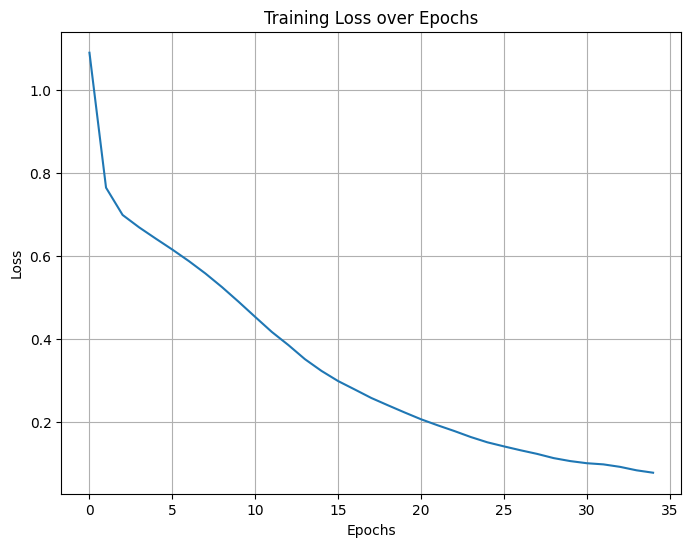

In [18]:
# plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

*Let's test the model's translation ability!*

In [19]:
# inference test using data sample inside and outside training dataset
prompt = ["ياكل هوا" ,"على عيني وراسي"]
for i in prompt: 
    text_gen("Translate it to English."  + i)


Gemma Output:
<start_of_turn>user
Translate it to English.ياكل هوا<end_of_turn>
<start_of_turn>model
To be unsuccessful; to fail.<end_of_turn>
Total time elapsed: 30.931269645690918s

Gemma Output:
<start_of_turn>user
Translate it to English.على عيني وراسي<end_of_turn>
<start_of_turn>model
In my eyes and on my heart<end_of_turn>
Total time elapsed: 0.4652895927429199s


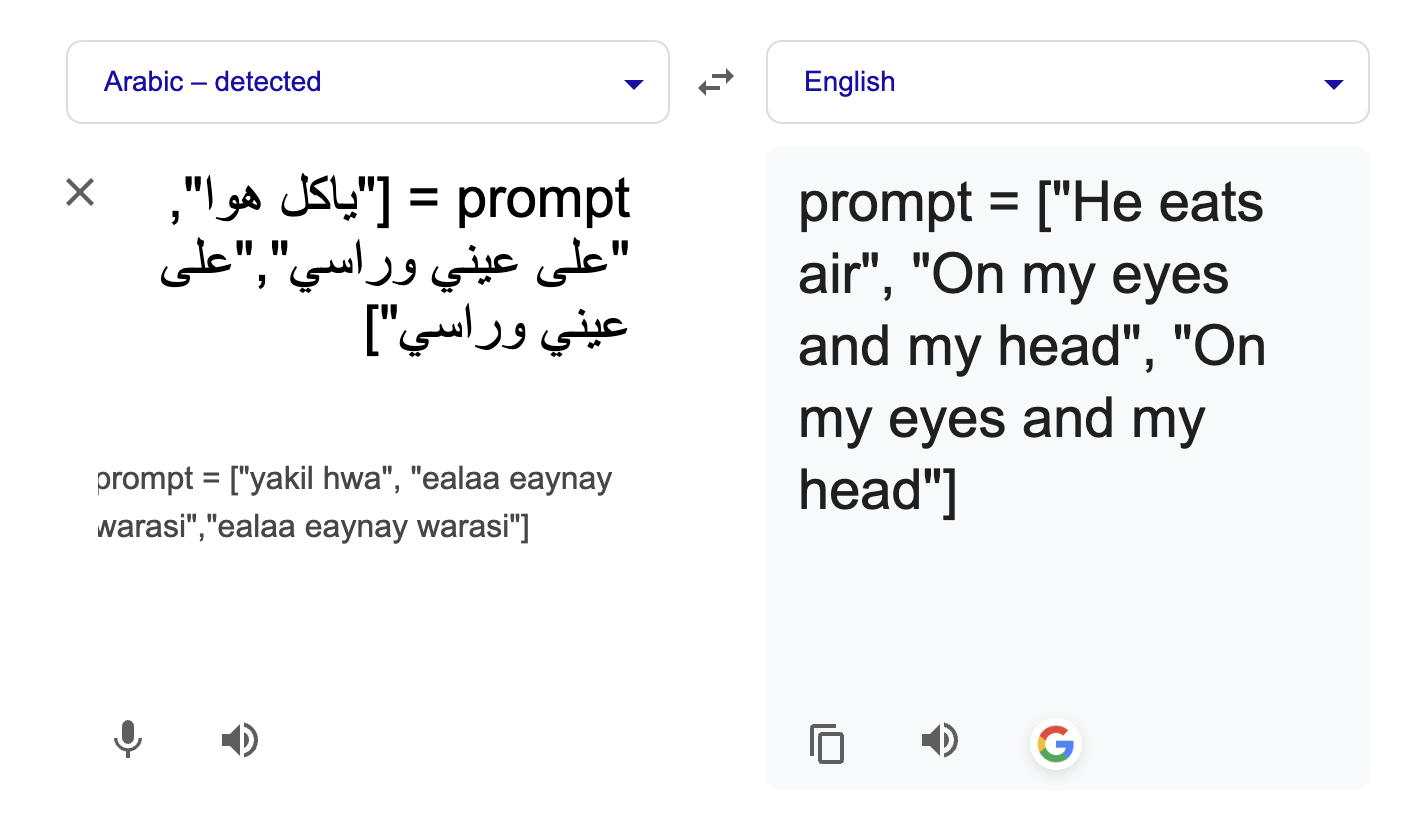

*As you can see, the model successfully provided correct results, whereas Google Translate did not perform as accurately.*

*Now, let’s assess its capability in the medical domain.*


In [20]:
# inference test
prompt = ["What substance is primarily filtered in the renal tubules with minimal secretion or re-absorption?", "Which drug has been linked to the development of suacute myelo-optic neuropathy (SMON) after prolonged use?"]
for i in prompt: 
    text_gen("Answer the question in English." + i)


Gemma Output:
<start_of_turn>user
Answer the question in English.What substance is primarily filtered in the renal tubules with minimal secretion or re-absorption?<end_of_turn>
<start_of_turn>model
Creatinine<end_of_turn>
Total time elapsed: 0.29731106758117676s

Gemma Output:
<start_of_turn>user
Answer the question in English.Which drug has been linked to the development of suacute myelo-optic neuropathy (SMON) after prolonged use?<end_of_turn>
<start_of_turn>model
Ribavirin<end_of_turn>
Total time elapsed: 0.3292579650878906s


*Results are correct and well-structured!*

In [21]:
# publish
# kaggle_username = os.environ["KAGGLE_USERNAME"]